In [168]:
import numpy as np
# uncomment and run the line below to install pyqsp
# %pip install pyqsp
from pyqsp import phases, response 
import matplotlib.pyplot as plt

[pyqsp.fixed_point_search] generating length 20 sequence in the Wx convention
[phi_fp]: gamma=0.9980368020961987


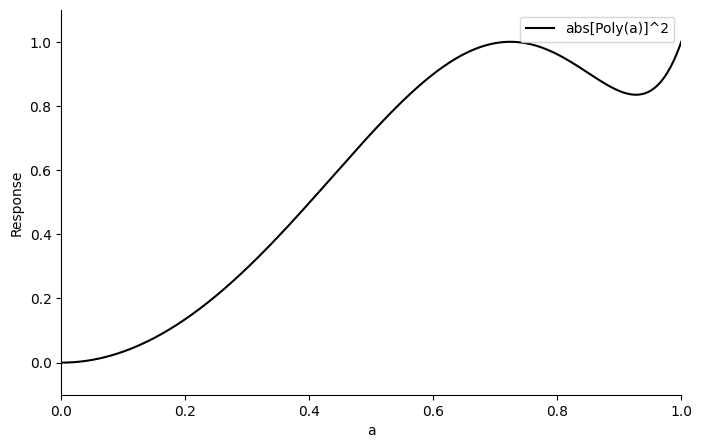

In [169]:
phis = phases.FPSearch().generate(10, 0.5)
response.PlotQSPResponse(phis, plot_positive_only=True, plot_probability = True, plot_tight_y=True, npts = 400, measurement='z')

[pyqsp.fixed_point_search] generating length 200 sequence in the Wx convention
[phi_fp]: gamma=0.9999997504010151


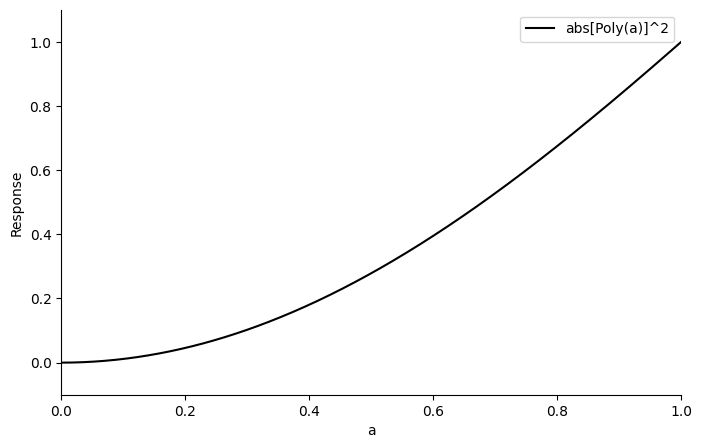

In [170]:
phis = phases.FPSearch().generate(100, 0.99)
response.PlotQSPResponse(phis, plot_positive_only=True, plot_probability = True, plot_tight_y=True, npts = 400, signal_operator='Wx', measurement='z')

In [417]:
def generate_phases(d, w):
    d = int(d)
    L = 2*d + 1
    phivec = []
    for k in range(1, d+1):
        phivec.append(np.arctan2(1, w * np.tan((2*k-1)*np.pi/L) ))
        phivec.append(np.arctan2(1, w * np.tan((2*k)*np.pi/L) ))
    return np.array(phivec)


In [460]:
######################################################################
# U = [a, sqrt(1-a^2)]
#     [sqrt(1-a^2),-a]  
# UZ = [a, -sqrt(1-a^2)]
#      [sqrt(1-a^2), a]
# XUZ = [sqrt(1-a^2), a]      (XU always swaps rows and UX always swaps columns)
#       [a, -sqrt(1-a^2)]
# We add a final X to  X@U@Z@UPhi so that QSP polynomials P(x) and Q(x) are swapped rowwise.
# note we could let the Pi matrix absorb the Z reflection by simply defining the phases to
# be arctan(...), instead of arctan(1,...). This is because
# Z@Pi = [e^(i(pi + p)), 0],
#        [0, e^(-i(pi + p))]
# and pi + arctan2(1,...) = arctan(...)
########################################################################

def Rx_response(a, phases):
    UPhi = np.array([[1, 0], [0, 1]])
    X = np.array([[0,1], [1,0]])
    Z = np.array([[1, 0], [0, -1]])
    U = np.array([
        [a, np.sqrt(1-a**2)],
        [np.sqrt(1-a**2), -a]
    ])
    for p in phases:
        Pi = np.array([
            [np.exp(1j * p), 0], 
            [0, np.exp(-1j * p)]
        ])
        UPhi = Pi @ U @ UPhi
    v = np.array([
        [1],
        [0]
    ])
    t = np.array([
        [0],
        [1]
    ])
    return t.T @ U @ UPhi @ v

In [458]:
np.log(2/0.3)/0.16

np.float64(11.856999905536759)

In [469]:
np.arccosh(1/0.3)/np.arccosh(1/np.sqrt(1-0.08**2))

np.float64(23.37269892506913)

In [465]:
xs = np.linspace(0,1,400)
phis = generate_phases(12, 0.08)
responses = []
for x in xs:
    responses.append(np.absolute(Rx_response(x, phis)[0,0])**2)

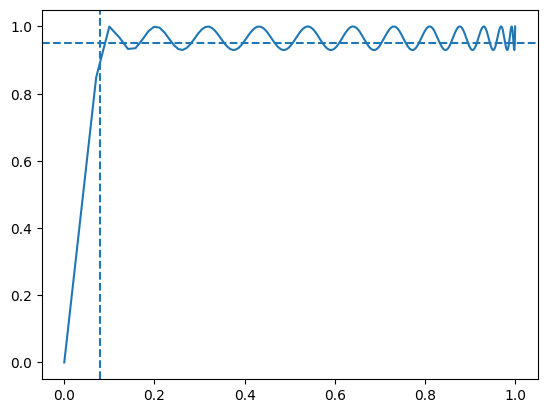

In [466]:
plt.plot(np.sqrt(1-xs**2), responses)
widthline = np.zeros(xs.shape)
#widthline[] = 1
plt.axvline(x=0.08, linestyle = '--')
plt.axhline(y=0.95, linestyle='--')

In [462]:
def generate_phases2(d, delta):
    avec = np.empty(d, float)
    L = 2*d + 1
    gamma = 1/np.cosh((1/L) * np.arccosh(1/delta))
    for i in range(d):
        avec[i] = 2 * np.arctan2(1,np.tan(2 * np.pi * (i+1)/L) * np.sqrt(1-gamma**2))
    bvec = -avec[::-1]
    return avec, bvec 

def gen_grover_resp(a, avec, bvec):
    d = len(avec)
    U = np.array([[1,0], [0,1]])
    for i in range(d):
        S_s  = - np.array([
            [1-(1-np.exp(-1j * avec[i]))*(1-a), -(1-np.exp(-1j * avec[i]))*np.sqrt(a * (1-a))],
            [-(1-np.exp(-1j * avec[i]))*np.sqrt(a * (1-a)), 1-(1-np.exp(-1j * avec[i]))*a]
        ])

        S_t = np.array([
            [1, 0],
            [0, np.exp(1j * bvec[i])]
        ])
        U = S_s @ S_t @ U 
    v = np.array([
        [np.sqrt(1-a)],
        [np.sqrt(a)]
    ])
    t = np.array([
        [1],
        [0]
    ])
    return  t.T @ U @ v



0.9914024889469455


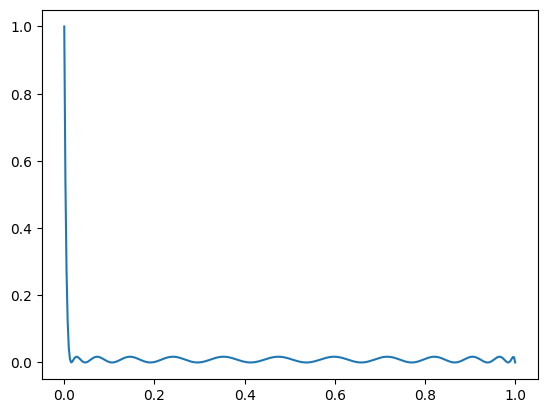

: 

In [ ]:
xs = np.linspace(0,1, 400)
w = 0.08
L = 24
delta = 1/np.cosh(L * np.arccosh(1/(1 - w**2)))
print(np.sqrt(1-delta**2))
avec, bvec = generate_phases2(12, delta)
responses = []
for x in xs:
    responses.append(np.absolute(gen_grover_resp(x, avec, bvec)[0,0])**2)
plt.plot(xs, responses)

In [242]:
w = 0.08
L = 25
delta = 1/np.cosh(L * np.arccosh(1/(1 - w**2)))
delta

np.float64(0.11691726128531357)

In [305]:
def generate(d, delta):
    L = 2 * d + 1
    kvec = np.arange(1, d + 1)
    gamma = 1 / np.cosh((1 / L) * np.arccosh(1 / delta))
    sg = np.sqrt(1 - gamma**2)
    avec = 2 * np.arctan2(1, (np.tan(2 * np.pi * kvec / L) * sg))

    bvec = - avec[::-1]
    phivec = np.zeros(2 * d)
    for k in range(d):
        phivec[2 * k] = -avec[d - k - 1] / 2
        phivec[2 * k + 1] = bvec[d - k - 1] / 2
    return phivec

def Wx_response(a, phases):
    UPhi = np.array([[np.exp(1j * phases[0]), 0], [0, -np.exp(1j * phases[0])]])
    U = np.array([[a, 1j * np.sqrt(1-a**2)],
                [1j * np.sqrt(1 - a**2), a]])
    for p in phases[1:]:
        Pi = np.array([[np.exp(1j * p), 0], [0, np.exp(-1j*p)]])
        UPhi = UPhi @ U @ Pi
    v = np.array([
        [1],
        [0]
    ])
    t = np.array([
        [1],
        [0]
    ])
    return t.T @ UPhi @ U @ v

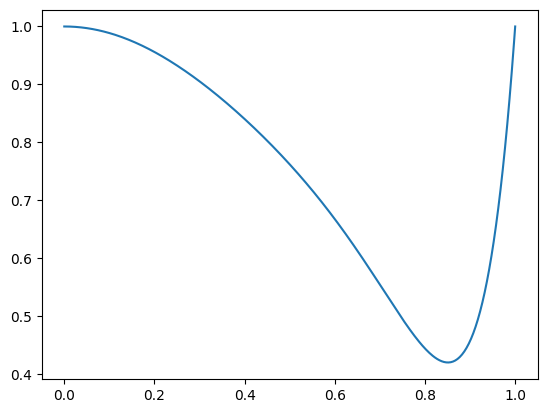

In [306]:
xs = np.linspace(0,1, 400)
phi = generate(10, 0.5)
responses = []
for x in xs:
    responses.append(np.absolute(Wx_response(x, phi)[0,0])**2)
plt.plot(xs, responses)
